# Data Cleanting 

In [308]:
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [309]:
df = pd.read_csv('FINAL_DF_YAWSSSS.csv')

In [310]:
#getting ridof non-needed column
df = df.drop('Unnamed: 0', axis=1)

In [311]:
#cleaning off the \nn in the calary column
df = df.replace(r'\n',' ', regex=True) 

In [312]:
#getting rid of all of the annoying 
df[str("salary")] = df[str("salary")].replace({'\$':''}, regex = True)
df[str("salary")] = df[str("salary")].replace({'a month':''}, regex = True)
df[str("salary")] = df[str("salary")].replace({'an hour':''}, regex = True)
df[str("salary")] = df[str("salary")].replace({'a year':''}, regex = True)
df[str("salary")] = df[str("salary")].replace({'an hour (Indeed est.)':''}, regex = True)
df[str("salary")] = df[str("salary")].replace({'(Indeed est.)':''}, regex = True)
df['salary'] = df['salary'].str.replace(r"\(.*\)","")

In [313]:
#making new df to hold values from salary being split 
splits = df["salary"].str.split("-", n = 1, expand = True) 
# putting them back into main frame in new columns low and high  
df["salary_low"]= splits[0] 
df["salary_high"]= splits[1] 
# Dropping old salary column
df.drop(columns =["salary"], inplace = True) 

In [314]:
df["salary_low"]= df.salary_low.replace({',':''}, regex = True)
df["salary_high"]= df.salary_high.replace({',':''}, regex = True)

In [315]:
#focusing on full time for analysis
dfft = df[df.job_type =='fulltime']

In [316]:
#filtering out only values that exist
dfft = dfft[dfft.salary_low != 'None'].drop_duplicates().dropna()
dfft = dfft[dfft.salary_high != 'None'].drop_duplicates().dropna()

In [317]:
dfft.reset_index(drop=True, inplace=True)

In [318]:
#extracting state and city from location 
dfft = dfft.join(dfft['Location'].str.split(',', 1, expand=True).rename(columns={0:'City', 1:'State'}))

In [319]:
#extracting just state info 
def strip_state(x):
    if x != None:
        return x[0:3]
    else:
        None
dfft['State Initials'] = dfft['State'].apply(strip_state)
#dfft.head()

In [320]:
#converting to numerica values (salary vals)
dfft['salary_high'] = dfft['salary_high'].apply(pd.to_numeric)
dfft['salary_low'] = dfft['salary_low'].apply(pd.to_numeric)

In [321]:
#dfft.to_csv('dffulltimecleaned.csv', encoding='utf-8')

# Analysis

predicting if values are higher or lower than the median salary for full time jobs. The intended result of this analysis would be to be able to determine future positions that are likely to pay well. 

In [322]:
#creating a column to hold the average pay between the high and low values. 
dfft['Average'] = dfft[['salary_low', 'salary_high']].mean(axis=1)

In [323]:
#nos taking the median value from the average calculated from the high and lows
median = dfft['Average'].median()

In [324]:
#the median salary for ft roles in this dataset is 16.5
median

16.5

In [325]:
#well paying jobs, the target jobs, will be those that are above the median salary value. 
dfft["above_med_sal"] = np.nan
dfft.ix[dfft["Average"] > median, "above_med_sal"] = 1 # assigning 1 to values higher 
dfft.ix[dfft["Average"] <= median, "above_med_sal"] = 0 # 0 to values less

/Users/adamkirstein/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/adamkirstein/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [326]:
#switching to int from float
dfft.above_med_sal = dfft.above_med_sal.astype(int)

In [327]:
dfft.dropna(inplace=True)

In [328]:
#val_counts = dfft.groupby('job_title')['job_title'].count().sort_values()

In [329]:
#val_counts[-5:].plot(kind='barh')

In [330]:
#salary counts 
#dfft.Average.value_counts().plot(kind='bar')

In [331]:
#baseline shows a 76% rate for non-above median. higher than 50% chance of predicting lower than median. 
dfft['above_med_sal'].value_counts()

0    6850
1    2504
Name: above_med_sal, dtype: int64

# Random Forest 

In [332]:
#estimating salary by state 

In [339]:
#training with no test/train splits
model = RandomForestClassifier(n_estimators=500, oob_score=True)
#creating dummy vars for states
df_state_dummy = pd.get_dummies(dfft['State Initials'])
#assigning dummy to x and above median sal to y 
x = df_state_dummy
y = dfft['above_med_sal']
X_train1, X_test1, y_train1, y_tes1t = train_test_split(x, y, test_size=0.25, random_state=42)
#training and cross validating random forest
cv_model = cross_val_score(model, X_train1, y_train1, cv=10)
print ('Cross-validated scores:', cv_model)
print( 'Average score:', cv_model.mean())
print ('Standard deviation of score:', cv_model.std())
model_fitted = model.fit(X_train1, y_train1)
print (model.oob_score_)

Cross-validated scores: [0.96870555 0.97012802 0.97150997 0.978602   0.9743224  0.96433666
 0.9743224  0.97717546 0.9743224  0.96861626]
Average score: 0.9722041116815501
Standard deviation of score: 0.0041341265710795475
0.9722024233784747


In [340]:
ypred = model_fitted.predict(X_test1)

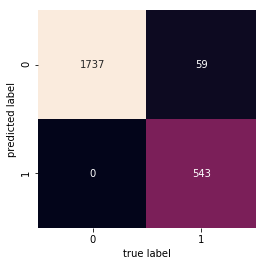

In [338]:
#creating confusion matrix. I am finding that an untuned, unbalanced rf is predicting rather well. 
mat = confusion_matrix(y_tes1t, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
#missclassifed 59 true (above med) vals. 

In [333]:
from sklearn import metrics
print(metrics.classification_report(ypred, y_tes1t))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1796
           1       0.90      1.00      0.95       543

   micro avg       0.97      0.97      0.97      2339
   macro avg       0.95      0.98      0.97      2339
weighted avg       0.98      0.97      0.98      2339



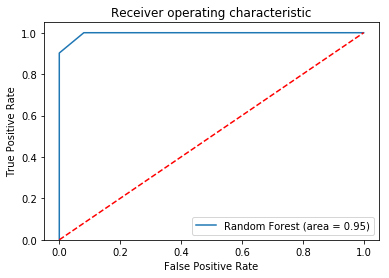

In [349]:
rf_roc_auc = roc_auc_score(y_tes1t, model_fitted.predict(X_test1))
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_tes1t, model_fitted.predict_proba(X_test1)[:,1])
plt.figure()
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC')

plt.show()
